In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
# ----------------------------
# 1-1) 1분 인덱스 보장 
# ----------------------------
def ensure_minutely_index(df, time_col = None):
    df = df.copy()

    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df index가 DatetimeIndex가 아님. time_col을 지정하거나 index를 datetime으로 설정해줘.")

    df = df.sort_index()

    # 1분 간격으로 리인덱싱
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="min")
    df = df.reindex(full_idx)

    return df

In [3]:
# ----------------------------
# 1-2) 결측 보간
# ----------------------------
def fill_missing_timewise(df, method = "time"):
    """
    - time interpolation: 시간축 기반 선형 보간
    - 남는 NaN: 앞/뒤 채움(필요시)
    """
    df = df.copy()

    # 숫자형만 보간
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].interpolate(method=method, limit_direction="both")

    # 그래도 남는 결측이 있으면(맨 앞/뒤 전부 NaN인 구간 등)
    df[num_cols] = df[num_cols].ffill().bfill()

    return df

In [4]:
def add_rolling_features(df, target_cols, windows=[60, 120, 1440]):
    """
    시간 기반 이동 통계 특징 추가
    
    Parameters:
    - df: 1분 단위 DataFrame
    - target_cols: 통계를 계산할 컬럼들
    - windows: 이동 윈도우 크기 (분 단위)
               [60=1시간, 120=2시간, 1440=24시간]
    """
    df = df.copy()
    
    for col in target_cols:
        for window in windows:
            # 이동 평균
            df[f'{col}_rolling_mean_{window}min'] = df[col].rolling(
                window=window, min_periods=1
            ).mean()
            
            # 이동 표준편차
            df[f'{col}_rolling_std_{window}min'] = df[col].rolling(
                window=window, min_periods=1
            ).std()
            
            # 이동 최소값
            df[f'{col}_rolling_min_{window}min'] = df[col].rolling(
                window=window, min_periods=1
            ).min()
            
            # 이동 최대값
            df[f'{col}_rolling_max_{window}min'] = df[col].rolling(
                window=window, min_periods=1
            ).max()
    
    return df


In [5]:
def add_time_features(df):
    """
    시간 관련 특징 추가
    """
    df = df.copy()
    
    # 시간 (0-23)
    df['hour'] = df.index.hour
    
    # 요일 (0=월요일, 6=일요일)
    df['dayofweek'] = df.index.dayofweek
    
    # 월 (1-12)
    df['month'] = df.index.month
    
    # 주말 여부
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # 시간대 구분 (새벽/오전/오후/저녁)
    df['time_of_day'] = pd.cut(
        df.index.hour,
        bins=[0, 6, 12, 18, 24],
        labels=[0, 1, 2, 3],
        include_lowest=True
    ).astype(int)
    
    return df


In [6]:
# ----------------------------
# 2) 30일 윈도우 특징 + 10분 뒤 예측 타깃 생성
# ----------------------------
def make_feature_window_dataset_minutely(df_1min, target_col, window_days = 30, horizon_minutes =10, step = 10, target_mode: str = "point"):
    """
    df_1min: 1분 주파수 DataFrame
    window_days: 과거 윈도우(30일)
    horizon_minutes: 몇 분 뒤를 예측할지 (10분)
    step: 샘플 생성 간격(분). 10분 간격 추천.
    target_mode:
      - "point": y(t + horizon) 단일값 예측 (기본)
      - "mean": [t+1 ... t+horizon] 평균 예측
      - "sum":  [t+1 ... t+horizon] 합 예측
    """
    if target_col not in df_1min.columns:
        raise ValueError(f"target_col='{target_col}' 컬럼이 df에 없음.")

    df = df_1min.copy()
    cols = df.columns.tolist()

    window_len = window_days * 24 * 60  # minutes
    H = int(horizon_minutes)

    values = df[cols].to_numpy(dtype=np.float64)
    y_all = df[target_col].to_numpy(dtype=np.float64)
    idx = df.index

    feats, ys, ts = [], [], []

    # 마지막 가능한 start: start+window_len+H <= len(df)
    max_start = len(df) - window_len - H
    if max_start <= 0:
        raise ValueError("데이터가 윈도우(30일)+horizon(10분)보다 짧음.")

    # 특징: 각 컬럼별 윈도우 통계 + 마지막 값
    feature_names = []
    for c in cols:
        feature_names += [f"{c}__mean", f"{c}__std", f"{c}__min", f"{c}__max", f"{c}__last"]

    for start in range(0, max_start, step):
        end = start + window_len  # 윈도우 끝(현재 시점 t)

        w = values[start:end, :]  # 과거 30일
        w_mean = np.nanmean(w, axis=0)
        w_std  = np.nanstd(w, axis=0)
        w_min  = np.nanmin(w, axis=0)
        w_max  = np.nanmax(w, axis=0)
        w_last = w[-1, :]

        x = np.concatenate([w_mean, w_std, w_min, w_max, w_last], axis=0)

        # 타깃 생성
        if target_mode == "point":
            y_target = y_all[end + H]  # t+horizon분의 값
            t_target = idx[end + H]
        elif target_mode == "mean":
            seg = y_all[end+1:end+H+1]  # 다음 horizon분
            y_target = float(np.nanmean(seg))
            t_target = idx[end + H]
        elif target_mode == "sum":
            seg = y_all[end+1:end+H+1]
            y_target = float(np.nansum(seg))
            t_target = idx[end + H]
        else:
            raise ValueError("target_mode는 'point'|'mean'|'sum' 중 하나여야 함.")

        feats.append(x)
        ys.append(y_target)
        ts.append(t_target)

    X = np.vstack(feats).astype(np.float32)
    y = np.array(ys, dtype=np.float32)
    t_target = pd.DatetimeIndex(ts)

    return X, y, t_target, feature_names

In [7]:
# ----------------------------
# 3) 시간순 분할 + 학습/예측 + 저장 + 평가
# ----------------------------
def train_with_time_features(df_raw,
    target_col = "Q_in",
    time_col = "SYS_TIME",
    window_days = 30,
    horizon_minutes = 10,
    step = 10,
    target_mode = "point",
    test_ratio = 0.2,
    out_csv = "pred_Q_in_10min.csv"
):
    # 1) 1분 인덱스 보장 + 결측 보간
    df_1min = ensure_minutely_index(df_raw, time_col=time_col)
    df_1min = fill_missing_timewise(df_1min, method="time")
    
    # 2) 시간 특성 추가
    df_1min = add_time_features(df_1min)
    
    # 3) 이동 통계 특징 추가
    feature_cols = df_1min.select_dtypes(include=[np.number]).columns.tolist()
    df_1min = add_rolling_features(
        df_1min, 
        target_cols=[target_col],  # 또는 모든 수치형 컬럼
        windows=[60, 120, 1440]  # 1시간, 2시간, 24시간
    )
    
    # 4) 30일 윈도우 특징 + 10분 뒤 타깃 생성
    # (기존 make_feature_window_dataset_minutely 함수 사용)
    X, y, t_target, feature_names = make_feature_window_dataset_minutely(
        df_1min,
        target_col=target_col,
        window_days=window_days,
        horizon_minutes=horizon_minutes,
        step=step
    )

    # (3) 시간순 split
    n = len(y)
    n_test = int(np.floor(n * test_ratio))
    n_train = n - n_test
    if n_train <= 0 or n_test <= 0:
        raise ValueError("train/test 분할 실패. 데이터 길이 또는 test_ratio 확인.")

    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test   = X[n_train:], y[n_train:]
    t_test           = t_target[n_train:]

    # (4) 모델: 스케일링 + 다중선형회귀
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LinearRegression())
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).astype(np.float32)

    # (5) 성능
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    eps = 1e-6
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), eps))) * 100.0
    r2 = r2_score(y_test, y_pred)
    metrics = {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape, "R2": r2}

    # (6) 저장: 시간 인덱스 + 실제/예측
    out = pd.DataFrame({
        "time": t_test,
        "y_true": y_test,
        "y_pred": y_pred
    }).set_index("time")

    out.to_csv(out_csv, encoding="utf-8-sig")

    return df_1min, out, metrics, feature_names, model

In [8]:
# ----------------------------
# 4) 시각화
# ----------------------------
def plot_results(out: pd.DataFrame, title: str = "Q_in: True vs Pred (10-min ahead, 1-min data, 30-day window, 10-min step)"):
    plt.figure()
    plt.plot(out.index, out["y_true"], label="true")
    plt.plot(out.index, out["y_pred"], label="pred")
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("Q_in")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.scatter(out["y_true"], out["y_pred"])
    plt.title("Pred vs True (scatter)")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.tight_layout()
    plt.show()

    resid = out["y_true"] - out["y_pred"]
    plt.figure()
    plt.plot(out.index, resid)
    plt.title("Residual (true - pred)")
    plt.xlabel("time")
    plt.ylabel("residual")
    plt.tight_layout()
    plt.show()

R2: 0.7268120050430298 
RMSE: 41.26041683102962 
MAE: 26.819761276245117 
MAPE(%): 86644616.0 



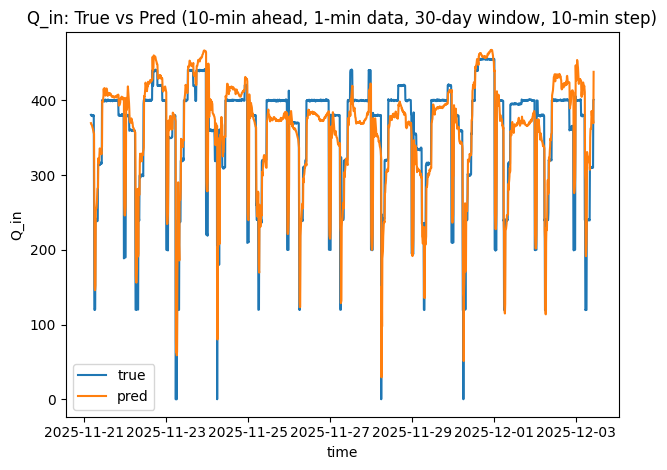

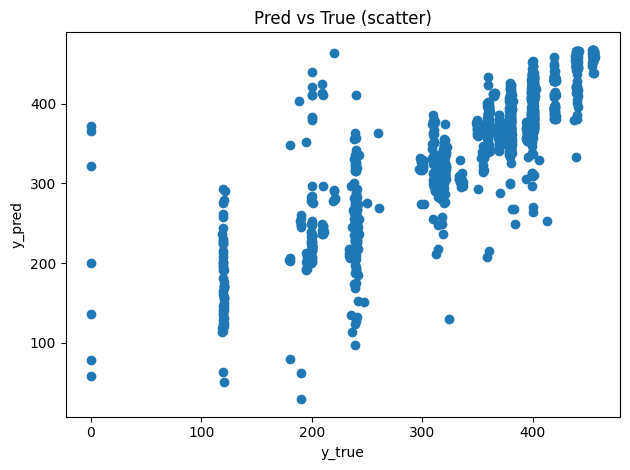

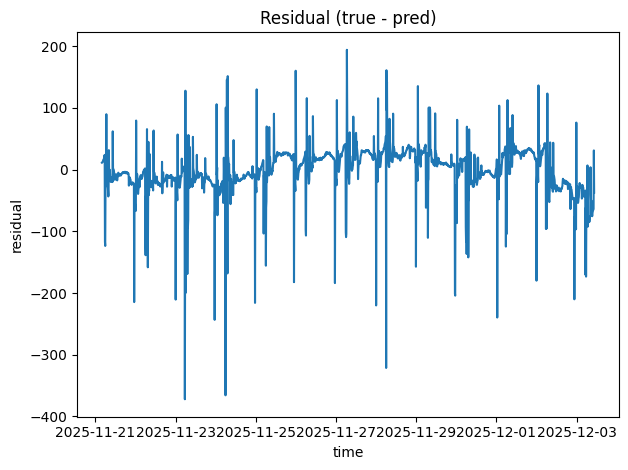

In [11]:
df_raw = pd.read_csv("../../data/processed/flow_processed.csv")  # time_col이 있으면 포함

df_raw = df_raw.drop(columns=["flow_TankA", "flow_TankB"])

df_1min, out, metrics, feat_names, model = train_with_time_features(
    df_raw,
    target_col="Q_in",
    time_col="SYS_TIME",      # 이미 index가 datetime이면 None
    window_days=30,
    horizon_minutes=10,
    step=10,
    target_mode="mean",
    test_ratio=0.2,
    out_csv="pred_Q_in_10min.csv"
)
print(f'R2: {metrics["R2"]} \nRMSE: {metrics["RMSE"]} \nMAE: {metrics["MAE"]} \nMAPE(%): {metrics["MAPE(%)"]} \n')
plot_results(out)